In [1]:
from IPython.display import clear_output as cls
!pip install scipy nibabel
cls()

In [2]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf

# Data
from glob import glob
from tqdm import tqdm
import nibabel as nib
from scipy import ndimage

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Sequential
from keras.layers import Layer, Conv3D, BatchNormalization, MaxPool3D, GlobalAveragePooling3D as GAP3D, Dense, Dropout, InputLayer

# Optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
root_path = "/content/drive/MyDrive/n171_smwp1"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def load_nii(path):
    '''The function takes the path and loads the respective NII file.'''
    scan = nib.load(path)
    scan = scan.get_fdata()
    return scan

In [7]:
Images = glob(root_path+ "/*")

In [8]:
len(Images)

171

In [9]:
scan = load_nii(Images[0])
print(f"Original Shape : {scan.shape}")

Original Shape : (113, 137, 113)


In [21]:
def process_scan(scan, desired_dims=(60,60,30)):

    # Define range for normalization
    min, max = -1000, 400

    # define the values
    scan[scan < min] = min
    scan[scan > max] = max

    # normalize the images
    norm_sc = (scan - min)/(max - min)
    norm_sc = norm_sc.astype('float32')

    # Resizing The Scan
    curr_h, curr_w, curr_d = norm_sc.shape
    result_h, result_w, result_d = desired_dims

    # Use cubic spline interpolation to get results
    h_f = result_h/curr_h
    width_f = result_w/curr_w
    d_f = result_d/curr_d

    # resize the scan
    resized_scan = ndimage.zoom(norm_sc, zoom=(h_f, width_f, d_f), order=3)

    # convert the scan to single channel dimension
    rt_scan = tf.expand_dims(resized_scan, axis=-1)

    # Return the final Scan
    return rt_scan

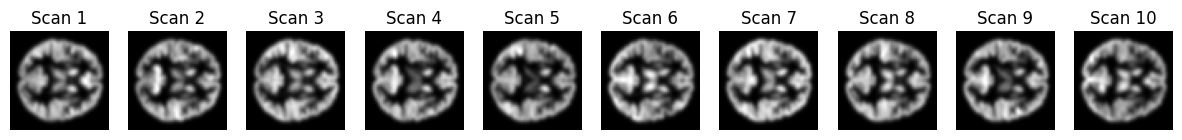

In [18]:
import random

# Select a random sample of scans
random_indices = random.sample(range(len(Images)), 10)

# Process the selected scans
processed_scans = [process_scan(load_nii(Images[i])) for i in random_indices]

# Display the scans
fig, axes = plt.subplots(1, len(random_indices), figsize=(15, 15))
for i, scan in enumerate(processed_scans):
    axes[i].imshow(scan[:, :, scan.shape[2] // 2], cmap='gray')
    axes[i].set_title(f"Scan {i+1}")
    axes[i].axis('off')

plt.show()


In [26]:
def load_data(paths, label=0):

    scans = np.empty(shape=(len(paths), 60, 60, 30, 1), dtype='float32')
    labels = np.empty(shape=(len(paths),), dtype='int32')

    # Iterate through each scan
    for i, path in tqdm(enumerate(paths), desc="Loading"):

        # load the scans
        scan_1 = load_nii(path)

        # preprocess the scans
        pr_scan = process_scan(scan_1, desired_dims=(60,60,30))
        scans[i] = pr_scan
        labels[i] = label

    # Return the data
    return scans, labels

In [20]:
all_scans,all_labels = load_data(Images)

Loading: 171it [00:42,  4.03it/s]


In [22]:
import pandas as pd

# Load the CSV file as a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Print the DataFrame
print(df)

             ID  PT500  PT4000
0    smwp1_0001   25.0    72.5
1    smwp1_0002    5.0    10.0
2    smwp1_0003    5.0    45.0
3    smwp1_0004    5.0    15.0
4    smwp1_0005    2.5    62.5
..          ...    ...     ...
166  smwp1_0167    0.0    27.5
167  smwp1_0168   37.5     2.5
168  smwp1_0169    7.5    10.0
169  smwp1_0170    0.0    -2.5
170  smwp1_0171   10.0    57.5

[171 rows x 3 columns]


In [27]:
pt500_series = df['PT500']
pt500_values = pt500_series.values
pt500_list = pt500_values.tolist()
print(pt500_list)

[25.0, 5.0, 5.0, 5.0, 2.5, 10.0, 10.0, 17.5, 7.5, 15.0, 22.5, 30.0, 37.5, 12.5, 12.5, 2.5, 5.0, 10.0, 30.0, 0.0, 20.0, 5.0, 2.5, -2.5, 7.5, 10.0, -5.0, 0.0, 12.5, 12.5, 7.5, 7.5, 15.0, 5.0, 0.0, 5.0, 7.5, 20.0, 12.5, 5.0, 12.5, 22.5, 2.5, 2.5, 10.0, 25.0, 7.5, 20.0, 12.5, 15.0, 10.0, -2.5, 22.5, 12.5, 2.5, 5.0, 17.5, 0.0, 7.5, 20.0, 2.5, 12.5, 15.0, 10.0, 15.0, 17.5, 27.5, 20.0, 17.5, 2.5, 17.5, 5.0, 12.5, 0.0, 10.0, 17.5, 15.0, 2.5, 2.5, 15.0, 17.5, 5.0, 20.0, 17.5, 7.5, 50.0, 0.0, 5.0, 25.0, 25.0, 0.0, 0.0, 10.0, 15.0, 0.0, 22.5, 2.5, 10.0, 5.0, 10.0, 10.0, 10.0, 12.5, 20.0, 0.0, 7.5, 8.75, 15.0, 12.5, 12.5, 5.0, 15.0, 22.5, 25.0, 7.5, 17.5, 0.0, 32.5, -2.5, 10.0, 7.5, 0.0, 5.0, 5.0, 0.0, 17.5, 5.0, 37.5, 25.0, 27.5, 10.0, 10.0, 12.5, 10.0, 12.5, 2.5, 20.0, 32.5, 7.5, 5.0, 5.0, 7.5, 0.0, 27.5, 17.5, 5.0, 15.0, 2.5, 20.0, 10.0, 20.0, 7.5, 12.5, 10.0, 32.5, 22.5, 5.0, 2.5, 30.0, 0.0, 17.5, 12.5, 2.5, 17.5, 12.5, 2.5, 0.0, 37.5, 7.5, 0.0, 10.0]


In [29]:
from keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_scans.reshape(all_scans.shape[0], -1), df['PT500'], test_size=0.2, random_state=42)

def create_cnn_regression_model(input_shape):
    model = models.Sequential()

    # Convolutional Layers
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(1024, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(1024, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(2048, kernel_size=(3, 3, 3), activation='relu'))

    # Pooling Layers
    def add_maxpooling_layer():
        if model.output_shape[1] >= 2 and model.output_shape[2] >= 2 and model.output_shape[3] >= 2:
            model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    add_maxpooling_layer()
    add_maxpooling_layer()
    add_maxpooling_layer()
    add_maxpooling_layer()
    add_maxpooling_layer()

    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(1, activation='linear'))

    return model


In [30]:
# Define the input shape based on the preprocessed scan dimensions
input_shape = (60, 60, 30, 1)

# Create the CNN regression model
model = create_cnn_regression_model(input_shape)

# Compile the model with accuracy as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 58, 58, 28, 32)    896       
                                                                 
 conv3d_1 (Conv3D)           (None, 56, 56, 26, 32)    27680     
                                                                 
 conv3d_2 (Conv3D)           (None, 54, 54, 24, 64)    55360     
                                                                 
 conv3d_3 (Conv3D)           (None, 52, 52, 22, 64)    110656    
                                                                 
 conv3d_4 (Conv3D)           (None, 50, 50, 20, 128)   221312    
                                                                 
 conv3d_5 (Conv3D)           (None, 48, 48, 18, 128)   442496    
                                                                 
 conv3d_6 (Conv3D)           (None, 46, 46, 16, 256)   8

In [31]:
print(X_train.shape)

(136, 108000)


In [32]:
print(model.input_shape)

(None, 60, 60, 30, 1)


In [33]:
X_train = X_train.reshape((X_train.shape[0], 60, 60, 30, 1))

In [34]:
from keras.utils import to_categorical

In [35]:
y_train_cat = to_categorical(y_train)

In [36]:
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
7/7 [==============================] - 1416s 113s/step - loss: 46.8275 - accuracy: 0.7491 - val_loss: 6.3715 - val_accuracy: 0.9804
Epoch 2/10
7/7 [==============================] - 178s 26s/step - loss: 2.3280 - accuracy: 0.9715 - val_loss: 0.0202 - val_accuracy: 0.9804
Epoch 3/10
7/7 [==============================] - 183s 26s/step - loss: 0.0445 - accuracy: 0.9804 - val_loss: 0.0200 - val_accuracy: 0.9804
Epoch 4/10
7/7 [==============================] - 183s 26s/step - loss: 0.2248 - accuracy: 0.8825 - val_loss: 0.0193 - val_accuracy: 0.9804
Epoch 5/10
7/7 [==============================] - 182s 26s/step - loss: 9.4195 - accuracy: 0.9003 - val_loss: 0.0348 - val_accuracy: 0.9804
Epoch 6/10
7/7 [==============================] - 175s 25s/step - loss: 0.0595 - accuracy: 0.9804 - val_loss: 0.0473 - val_accuracy: 0.9804
Epoch 7/10
7/7 [==============================] - 181s 26s/step - loss: 0.0444 - accuracy: 0.9715 - val_loss: 0.0333 - val_accuracy: 0.9804
Epoch 8/10
7/7 [=

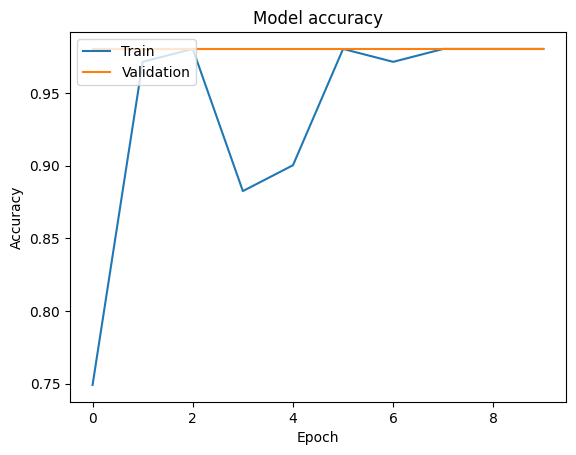

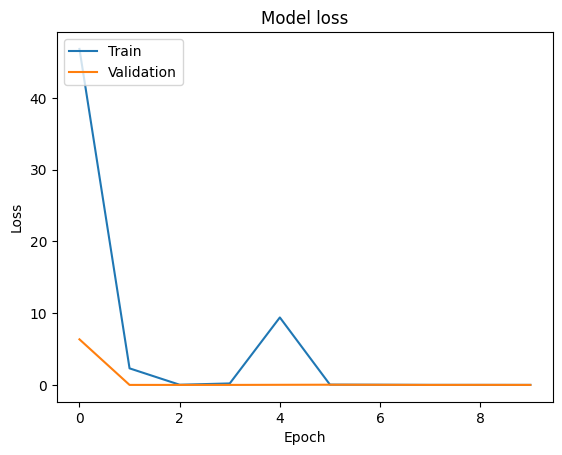

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [43]:
import numpy as np
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Compute mean squared error for each epoch
train_mses = np.array(train_losses)
val_mses = np.array(val_losses)

# Calculate mean loss for training and validation sets
mean_train_mse = np.mean(train_mses)
mean_val_mse = np.mean(val_mses)


# Print the values
print(f'Mean Training MSE: {mean_train_mse:.4f}')
print(f'Mean Validation MSE: {mean_val_mse:.4f}')


Mean Training MSE: 5.9017
Mean Validation MSE: 0.6612
